In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = os.environ.get("LANGCHAIN_ENDPOINT")
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")
HUGGINGFACEHUB_API_TOKEN = os.environ.get("HUGGINGFACEHUB_API_TOKEN")

In [3]:
from huggingface_hub import login

login(HUGGINGFACEHUB_API_TOKEN)

/home/shakiba/anaconda3/envs/taxonomy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/shakiba/.cache/huggingface/token
Login successful


In [4]:
# from langchain_community.llms import LlamaCpp

from langchain_community.embeddings import OllamaEmbeddings


# LLM
# n_gpu_layers = 1  # Metal set to 1 is enough.
# n_batch = 512  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.

# llm = LlamaCpp(
#     model_path="C:/Users/Sshakiba/.cache/lm-studio/models/LM Studio Community/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf",
#     n_gpu_layers=n_gpu_layers,
#     n_batch=n_batch,
#     n_ctx=2048,
#     f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
#     verbose=True,
#     embedding=True
# )

# import llama_cpp

# model_path="C:/Users/Sshakiba/.cache/lm-studio/models/LM Studio Community/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"

# llm = llama_cpp.Llama(model_path=model_path, embedding=True)


embeddings = OllamaEmbeddings(model="llama3", base_url='http://localhost:11434', num_thread=8, temperature=0)



In [5]:
import os
import requests
import sqlite3
import pandas as pd
import shutil


# db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# # The backup lets us restart for each tutorial section
# backup_file = "travel2.backup.sqlite"
# overwrite = False
# if overwrite or not os.path.exists(local_file):
#     response = requests.get(db_url)
#     response.raise_for_status()  # Ensure the request was successful
#     with open(local_file, "wb") as f:
#         f.write(response.content)

# # Backup - we will use this to "reset" our DB in each section
# shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';", conn
).name.tolist()
tdf = {}
for t in tables:
    tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)



In [6]:
tdf

{'aircrafts_data':   aircraft_code                model  range
 0           773       Boeing 777-300  11100
 1           763       Boeing 767-300   7900
 2           SU9  Sukhoi Superjet-100   3000
 3           320      Airbus A320-200   5700
 4           321      Airbus A321-200   5600
 5           319      Airbus A319-100   6700
 6           733       Boeing 737-300   4200
 7           CN1   Cessna 208 Caravan   1200
 8           CR2   Bombardier CRJ-200   2700,
 'airports_data':     airport_code                                      airport_name  \
 0            ATL  Hartsfield-Jackson Atlanta International Airport   
 1            PEK             Beijing Capital International Airport   
 2            DXB                       Dubai International Airport   
 3            LAX                 Los Angeles International Airport   
 4            HND                              Tokyo Haneda Airport   
 ..           ...                                               ...   
 110          JRO

In [7]:
example_time = pd.to_datetime(
    tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
).max()
current_time = pd.to_datetime("now").tz_localize(example_time.tz)
time_diff = current_time - example_time

tdf["bookings"]["book_date"] = (
    pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
    + time_diff
)

datetime_columns = [
    "scheduled_departure",
    "scheduled_arrival",
    "actual_departure",
    "actual_arrival",
]
for column in datetime_columns:
    tdf["flights"][column] = (
        pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
    )

for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)
del df
del tdf
conn.commit()
conn.close()

db = local_file  # We'll be using this local file as our DB in this tutorial

In [8]:
import re
import numpy as np
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

In [9]:
docs

[{'page_content': '## Invoice Questions\n\n1. Can I receive an invoice for my booked flight?\n\nYes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.\n\n2. Do I need to reconfirm my flight?\n\nNo, reconfirmation of SWISS flights is not required.\n\n3. Can I check for availability and fares without booking a flight?\n\nYes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.\n\n4. What are the flight tariff categories?\n\nThe letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.\n\n5. Where can I find the fare condition

In [9]:
# import json

# with open ("persian_docs.json", "r") as final:
#     persian_docs = json.load(final)

# persian_docs

[{'page_content': '## سوالات فاکتور\n\n1. آیا می توانم برای پرواز رزرو شده خود فاکتور دریافت کنم؟\n\nبله، ما می توانیم تا 100 روز پس از استفاده کامل از بلیط/سند، تأییدیه رزرو جدید را به صورت رایگان برای شما ارسال کنیم. کارمزدی 30.00 فرانک فرانک برای هر تراکنش (حداکثر 5 تائیدیه بلیت الکترونیکی) پس از این 100 روز دریافت می شود. بلیط الکترونیکی را می توان برای مقاصد صورتحساب استفاده کرد.\n\n2. آیا باید پرواز خود را دوباره تأیید کنم؟\n\nخیر، تایید مجدد پروازهای سوئیس لازم نیست.\n\n3. آیا می توانم بدون رزرو پرواز، در دسترس بودن و کرایه ها را بررسی کنم؟\n\nبله، می\u200cتوانید در دسترس بودن پرواز و کرایه\u200cها را بدون رزرو نهایی بررسی کنید. پرداخت تنها در آخرین مرحله و پس از وارد کردن اطلاعات شخصی شما انجام می شود.\n\n4. دسته بندی تعرفه پرواز چیست؟\n\nحروف B، E، G، H، K، L، M، Q، S، T، U، V، W، Y (کلاس اقتصادی)، C، D، J، P، Z (کلاس تجاری) و A ,F (First Class) برای نشان دادن دسته بندی قیمت های مختلف در کلاس های خدمات مختلف استفاده می شود.\n\n5. از کجا می توانم شرایط کرایه بلیط های رزرو شده خ

In [10]:
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embed_documents(
            [doc["page_content"] for doc in docs]
        )
        # print("*"*10)
        # print(embeddings)
        # print("*"*10)
        # print(type(embeddings))
        # vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, embeddings, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.create_embedding([query])
        # "@" is just a matrix multiplication in python
        scores = np.array(embed) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]

retriever = VectorStoreRetriever.from_docs(docs, embeddings)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

In [11]:
from langchain_core.runnables import ensure_config
from typing import Optional
import sqlite3
import pytz
from datetime import datetime, timedelta, date


@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str) -> str:
    """Cancel the user's ticket and remove it from the database."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

In [12]:
from typing import Optional, Union
from datetime import datetime, date


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

In [13]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

In [14]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

In [15]:
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage



def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [16]:
from langgraph.graph.message import add_messages, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [22]:
import json
from copy import deepcopy
from operator import itemgetter
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Literal,
    Optional,
    Sequence,
    Type,
    TypedDict,
    TypeVar,
    Union,
    overload,
)

import uuid

from langchain_community.chat_models.ollama import ChatOllama
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.language_models import LanguageModelInput
from langchain_core.messages import AIMessage, BaseMessage
from langchain_core.output_parsers.base import OutputParserLike
from langchain_core.output_parsers.json import JsonOutputParser
from langchain_core.output_parsers.pydantic import PydanticOutputParser
from langchain_core.outputs import ChatGeneration, ChatResult
from langchain_core.prompts import SystemMessagePromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable, RunnableLambda
from langchain_core.runnables.base import RunnableMap
from langchain_core.runnables.passthrough import RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.messages import ToolCall

DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": <name of the selected tool>,
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
"""  # noqa: E501

DEFAULT_RESPONSE_FUNCTION = {
    "name": "__conversational_response",
    "description": (
        "Respond conversationally if no other tools should be called for a given query."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "response": {
                "type": "string",
                "description": "Conversational response to the user.",
            },
        },
        "required": ["response"],
    },
}

_BM = TypeVar("_BM", bound=BaseModel)
_DictOrPydanticClass = Union[Dict[str, Any], Type[_BM]]
_DictOrPydantic = Union[Dict, _BM]



def _is_pydantic_class(obj: Any) -> bool:
    return True


def convert_to_ollama_tool(tool: Any) -> Dict:

    schema = deepcopy(tool.__dict__)
    properties = schema['args_schema'].construct().schema()['properties']
    for v in properties.values():
        if 'title' in v:
            del v['title']

    definition = {
        "name": schema["name"],
        "description": schema["description"],
        "params": properties,
    }
    # if "required" in schema:
    #     definition["required"] = schema["required"]
    return definition


class _AllReturnType(TypedDict):
    raw: BaseMessage
    parsed: Optional[_DictOrPydantic]
    parsing_error: Optional[BaseException]


def parse_response(message: BaseMessage) -> str:
    """Extract `function_call` from `AIMessage`."""
    if isinstance(message, AIMessage):
        kwargs = message.additional_kwargs
        if "function_call" in kwargs:
            if "arguments" in kwargs["function_call"]:
                return kwargs["function_call"]["arguments"]
            raise ValueError(
                f"`arguments` missing from `function_call` within AIMessage: {message}"
            )
        raise ValueError(
            "`function_call` missing from `additional_kwargs` "
            f"within AIMessage: {message}"
        )
    raise ValueError(f"`message` is not an instance of `AIMessage`: {message}")


class OllamaFunctions(ChatOllama):
    """Function chat model that uses Ollama API."""

    tool_system_prompt_template: str = DEFAULT_SYSTEM_TEMPLATE

    def __init__(self, **kwargs: Any) -> None:
        super().__init__(**kwargs)

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        return self.bind(functions=tools, **kwargs)

    @overload
    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        include_raw: Literal[True] = True,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _AllReturnType]:
        ...

    @overload
    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        include_raw: Literal[False] = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _DictOrPydantic]:
        ...

    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        include_raw: bool = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _DictOrPydantic]:
        """Model wrapper that returns outputs formatted to match the given schema.

        Args:
            schema: The output schema as a dict or a Pydantic class. If a Pydantic class
                then the model output will be an object of that class. If a dict then
                the model output will be a dict. With a Pydantic class the returned
                attributes will be validated, whereas with a dict they will not be.
            include_raw: If False then only the parsed structured output is returned. If
                an error occurs during model output parsing it will be raised. If True
                then both the raw model response (a BaseMessage) and the parsed model
                response will be returned. If an error occurs during output parsing it
                will be caught and returned as well. The final output is always a dict
                with keys "raw", "parsed", and "parsing_error".

        Returns:
            A Runnable that takes any ChatModel input and returns as output:

                If include_raw is True then a dict with keys:
                    raw: BaseMessage
                    parsed: Optional[_DictOrPydantic]
                    parsing_error: Optional[BaseException]

                If include_raw is False then just _DictOrPydantic is returned,
                where _DictOrPydantic depends on the schema:

                If schema is a Pydantic class then _DictOrPydantic is the Pydantic
                    class.

                If schema is a dict then _DictOrPydantic is a dict.

        Example: Pydantic schema (include_raw=False):
            .. code-block:: python

                from langchain_experimental.llms import OllamaFunctions
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                llm = OllamaFunctions(model="phi3", format="json", temperature=0)
                structured_llm = llm.with_structured_output(AnswerWithJustification)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")

                # -> AnswerWithJustification(
                #     answer='They weigh the same',
                #     justification='Both a pound of bricks and a pound of feathers weigh one pound. The weight is the same, but the volume or density of the objects may differ.'
                # )

        Example: Pydantic schema (include_raw=True):
            .. code-block:: python

                from langchain_experimental.llms import OllamaFunctions
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                llm = OllamaFunctions(model="phi3", format="json", temperature=0)
                structured_llm = llm.with_structured_output(AnswerWithJustification, include_raw=True)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
                # -> {
                #     'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ao02pnFYXD6GN1yzc0uXPsvF', 'function': {'arguments': '{"answer":"They weigh the same.","justification":"Both a pound of bricks and a pound of feathers weigh one pound. The weight is the same, but the volume or density of the objects may differ."}', 'name': 'AnswerWithJustification'}, 'type': 'function'}]}),
                #     'parsed': AnswerWithJustification(answer='They weigh the same.', justification='Both a pound of bricks and a pound of feathers weigh one pound. The weight is the same, but the volume or density of the objects may differ.'),
                #     'parsing_error': None
                # }

        Example: dict schema (method="include_raw=False):
            .. code-block:: python

                from langchain_experimental.llms import OllamaFunctions, convert_to_ollama_tool
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                dict_schema = convert_to_ollama_tool(AnswerWithJustification)
                llm = OllamaFunctions(model="phi3", format="json", temperature=0)
                structured_llm = llm.with_structured_output(dict_schema)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
                # -> {
                #     'answer': 'They weigh the same',
                #     'justification': 'Both a pound of bricks and a pound of feathers weigh one pound. The weight is the same, but the volume and density of the two substances differ.'
                # }


        """  # noqa: E501
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        is_pydantic_schema = _is_pydantic_class(schema)
        if schema is None:
            raise ValueError(
                "schema must be specified when method is 'function_calling'. "
                "Received None."
            )
        llm = self.bind_tools(tools=[schema], format="json")
        if is_pydantic_schema:
            output_parser: OutputParserLike = PydanticOutputParser(
                pydantic_object=schema
            )
        else:
            output_parser = JsonOutputParser()

        parser_chain = RunnableLambda(parse_response) | output_parser
        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | parser_chain, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | parser_chain

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        functions = kwargs.get("functions", [])
        if "functions" in kwargs:
            del kwargs["functions"]
        if "function_call" in kwargs:
            functions = [
                fn for fn in functions if fn["name"] == kwargs["function_call"]["name"]
            ]
            if not functions:
                raise ValueError(
                    "If `function_call` is specified, you must also pass a "
                    "matching function in `functions`."
                )
            del kwargs["function_call"]
        elif not functions:
            functions.append(DEFAULT_RESPONSE_FUNCTION)
        if _is_pydantic_class(functions[0]):
            functions = [convert_to_ollama_tool(fn) for fn in functions]
        system_message_prompt_template = SystemMessagePromptTemplate.from_template(
            self.tool_system_prompt_template
        )
        system_message = system_message_prompt_template.format(
            tools=json.dumps(functions, indent=2)
        )

        response_message = super()._generate(
            messages, stop=stop, run_manager=run_manager, **kwargs
        )
        chat_generation_content = response_message.generations[0].text
        if not isinstance(chat_generation_content, str):
            raise ValueError("OllamaFunctions does not support non-string output.")
        try:
            parsed_chat_result = json.loads(chat_generation_content)
        except json.JSONDecodeError:
            raise ValueError(
                f"""'{self.model}' did not respond with valid JSON. 
                Please try again. 
                Response: {chat_generation_content}"""
            )

        called_tool_name = parsed_chat_result["tool"].replace(' ', '')
        called_tool_arguments = parsed_chat_result["tool_input"]
        called_tool = next(
            (fn for fn in functions if fn["name"] == called_tool_name), None
        )
        if called_tool is None:
            raise ValueError(
                f"Failed to parse a function call from {self.model} output: "
                f"{chat_generation_content}"
            )
        if called_tool["name"] == 'answer_to_user':
            try:
                answer = json.loads(called_tool_arguments)['answer']
            except Exception:
                answer = str(called_tool_arguments)

            return ChatResult(
                generations=[
                    ChatGeneration(
                        message=AIMessage(
                            content=answer,
                        )
                    )
                ]
            )

        response_message_with_functions = AIMessage(
            content=chat_generation_content,
            additional_kwargs={
                "function_call": {
                    "name": called_tool_name,
                    "arguments": json.dumps(called_tool_arguments)
                    if called_tool_arguments
                    else "",
                },
            },
        )
        tool_call = ToolCall(name=called_tool_name, args=called_tool_arguments, id=str(uuid.uuid4()))
        response_message_with_functions.tool_calls.append(tool_call)

        return ChatResult(
            generations=[ChatGeneration(message=response_message_with_functions)]
        )

    @property
    def _llm_type(self) -> str:
        return "ollama_functions"

In [32]:
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.convert_to_openai import format_tool_to_openai_tool
from langgraph.prebuilt import ToolExecutor,ToolInvocation
from langchain_community.llms import HuggingFaceTextGenInference
from langchain_community.chat_models.huggingface import ChatHuggingFace
from langchain_community.llms import HuggingFaceHub
from langchain import PromptTemplate, LLMChain
# from langchain_community.llms import LlamaCpp
# from langchain_experimental.llms.ollama_functions import OllamaFunctions, convert_to_ollama_tool
from langchain.llms import Ollama



class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatOpenAI(model="gpt-3.5-turbo", max_tokens=500)
# llm = ChatHuggingFace(llm=model)
# from langchain_community.llms import LlamaCpp


# LLM
# n_gpu_layers = 1  # Metal set to 1 is enough.
# n_batch = 512  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.

# llm = LlamaCpp(
#     model_path="C:/Users/Sshakiba/.cache/lm-studio/models/LM Studio Community/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf",
#     n_gpu_layers=n_gpu_layers,
#     n_batch=n_batch,
#     n_ctx=2048,
#     f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
#     verbose=True,
#     embedding=True
# )


part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

functions = [convert_to_ollama_tool(fn) for fn in part_1_tools]
json_tools=json.dumps(functions, indent=2)
llm = OllamaFunctions(model='llama3', format='json', num_ctx=8192, num_thread=8, temperature=0.0)


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up.\n\n"
            "You have access to the following tools:\n\n"
            "{tools}\n\n"
            "You must always select one of the above tools and respond with only a JSON object matching the following schema:\n\n"
            "{{\n"
            "  \"tool\": <name of the selected tool>,\n"
            "  \"tool_input\": <parameters for the selected tool, matching the tool's JSON schema>\n"
            "}}\n"
            ""
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now(), tools=json_tools)

part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)


In [27]:
[convert_to_ollama_tool(tool) for tool in part_1_tools]

[{'name': 'tavily_search_results_json',
  'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.',
  'params': {'query': {'description': 'search query to look up',
    'type': 'string'}}},
 {'name': 'fetch_user_flight_information',
  'description': 'fetch_user_flight_information() -> list[dict] - Fetch all tickets for the user along with corresponding flight information and seat assignments.\n\n    Returns:\n        A list of dictionaries where each dictionary contains the ticket details,\n        associated flight details, and the seat assignments for each ticket belonging to the user.',
  'params': {}},
 {'name': 'search_flights',
  'description': 'search_flights(departure_airport: Optional[str] = None, arrival_airport: Optional[str] = None, start_time: Union[datetime.date, datetime.datetime, NoneType] = None, end_time: Union[datetime.date, datetime.

In [33]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    # "action" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"action": "action", END: END},
)
builder.add_edge("action", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

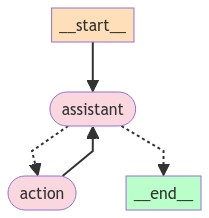

In [34]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [36]:
import uuid
import shutil

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hey. can you check when is my flight?",
    # "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original palce in each section
backup_file = "travel2.backup.sqlite"

shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "0474 690760",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hey. can you check when is my flight?
================================== Ai Message ==================================

{ "tool": "fetch_ user_flight_information", "tool_input": {} }
Tool Calls:
  fetch_user_flight_information (b295798e-d30b-4b6d-a361-e47bac331762)
 Call ID: b295798e-d30b-4b6d-a361-e47bac331762
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[]


ValueError: Received unsupported message type for Ollama.